This notebook will perform all the data processing and plotting of Fig. 3 and Supplementary Figs 2-8 in Crawford et al, 2024.

The input is the read count per barcode across all the sites and biological replicates. The code to create this data from the raw .fastqs is in the function xx.py on the GitHub repo xx.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
sns.set()
sns.set_style("ticks")
from matplotlib.colors import LogNorm
import logomaker
from collections import defaultdict

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['axes.linewidth'] = 0.4 # set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.4
matplotlib.rcParams['ytick.major.width'] = 0.4
matplotlib.rcParams['ytick.minor.width'] = 0.4
cm = 1/2.54

Matplotlib is building the font cache; this may take a moment.


In [3]:
barcode_df = pd.read_excel("msKDC006_barcode_df_v6f4a84f.xlsx", index_col=[0, 1, 2, 3]).reset_index()

# drop the double of msKDC006_49
barcode_df.drop_duplicates(inplace=True)

# drop site2 rep3 24h genome sample, because there is no matching plasmid sample
drop_index = barcode_df.loc[(barcode_df["site"] == 2) &\
                            (barcode_df["rep"] == 3) &\
                            (barcode_df["timepoint"] == 24) &\
                            (barcode_df["type"] == "genome"), :].index
barcode_df.drop(drop_index, axis=0, inplace=True)

In [4]:
genome_barcode_df = barcode_df.loc[barcode_df["type"] == "genome"]
plasmid_barcode_df = barcode_df.loc[barcode_df["type"] == "plasmid"]
raw_barcode_df = barcode_df.loc[barcode_df["timepoint"] == "raw"]
raw_barcode_df.head()

,site,rep,type,timepoint,AAAAACGCCG,AAAACGCGAC,AAAAGCGGCT,AAACACCTGC,AAACAGGCAC,AAACCGCATG,...,TTTCTGCCCA,TTTCTTCGCG,TTTGCGAGGT,TTTGCGTTCG,TTTGCTCCGC,TTTGGACCGG,TTTGGCCTTC,TTTGGTGTGC,TTTGTCGCAG,TTTTCCCACG
0,1,0,plasmid,raw,12,9,9,1,140.0,NaN,...,25,8,33,34.0,62.0,4,14,3,38,NaN
17,2,0,plasmid,raw,7,137,39,111,37.0,82.0,...,29,49,9,NaN,NaN,16,48,20,5,8.0
32,3,0,plasmid,raw,4,0,8,13,NaN,7.0,...,9,2,40,NaN,7.0,13,5,26,0,NaN


In [5]:
summed_plasmid_barcodes = plasmid_barcode_df.groupby(["site", "rep"]).sum()
summed_plasmid_barcodes["timepoint"] = 48
summed_plasmid_barcodes.set_index("timepoint", append=True, inplace=True)
summed_plasmid_barcodes.reset_index(inplace=True)

# rep 0 is the raw barcode counts of the plasmid pool before any transfection

/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


From all of this, I am going to use the summed plasmid count information & put a cut-off of 10 as the count.

# PROCESS BARCODE DATA:

In [6]:
# load in the donor information per barcode
site1_info = pd.read_excel("REditor_param_site1_summary.xlsx", index_col="barcode")[["PAM_position",
                                                                                     "donor_length",
                                                                                     "donor_direction",
                                                                                     "donor_center",
                                                                                     "chassis_number"]]
site2_info = pd.read_excel("REditor_param_site2_summary.xlsx", index_col="barcode")[["PAM_position",
                                                                                     "donor_length",
                                                                                     "donor_direction",
                                                                                     "donor_center",
                                                                                     "chassis_number"]]
site3_info = pd.read_excel("REditor_param_site3_summary.xlsx", index_col="barcode")[["PAM_position",
                                                                                     "donor_length",
                                                                                     "donor_direction",
                                                                                     "donor_center",
                                                                                     "chassis_number"]]

In [7]:
UMIs = np.linspace(0, len(site1_info), len(site1_info)+1)

In [8]:
# NEED TO MAKE A UNIQUE IDENTIFIER FOR EACH COMBINATION & APPEND ONTO SITE INFO
# --> this is because the barcodes aren't the same from site-to-site

UMIs = np.linspace(0, len(site1_info), len(site1_info)+1)

for umi_num, site1_index in enumerate(site1_info.index):
    info = site1_info.loc[site1_index, :]
    PAM = info["PAM_position"]
    length = info["donor_length"]
    direction = info["donor_direction"]
    center = info["donor_center"]
    chassis = info["chassis_number"]
    
    # find this combination in site 2 & site 3:
    site2_index = site2_info.loc[
        ((site2_info["PAM_position"] == PAM) &\
        (site2_info["donor_length"] == length) &\
        (site2_info["donor_direction"] == direction) &\
        (site2_info["donor_center"] == center) &\
        (site2_info["chassis_number"] == chassis)), :].index
    site3_index = site3_info.loc[
        ((site3_info["PAM_position"] == PAM) &\
        (site3_info["donor_length"] == length) &\
        (site3_info["donor_direction"] == direction) &\
        (site3_info["donor_center"] == center) &\
        (site3_info["chassis_number"] == chassis)), :].index
    
    # assign UMI to all three site info dataframes
    site1_info.loc[site1_index, "UMI"] = UMIs[umi_num]
    site2_info.loc[site2_index, "UMI"] = UMIs[umi_num]
    site3_info.loc[site3_index, "UMI"] = UMIs[umi_num]

In [9]:
def site_processing_for_merge(df):
    """
    Process individual site dataframes for merge with their site info
    """
    df = df.drop(["site"], axis=1).dropna(axis="columns")
    df = df.set_index(["rep", "timepoint", "type"]).transpose()
    df = df.rename({"genome": "genome_rc", "plasmid": "plasmid_rc"}, axis=1)
    df = df.sort_index(axis=1, level=0)
    df.index.rename("barcode", inplace=True)
    return df

In [10]:
plasmid_barcode_df = barcode_df.loc[barcode_df["type"] == "plasmid"]
summed_plasmid_barcodes = plasmid_barcode_df.groupby(["site", "rep"]).sum()
summed_plasmid_barcodes["timepoint"] = 48
summed_plasmid_barcodes["type"] = "plasmid"
summed_plasmid_barcodes.set_index(["timepoint", "type"], append=True, inplace=True)
summed_plasmid_barcodes.reset_index(inplace=True)
# drop "0" replicates --> aka the raw plasmid reads, since there is no matching genome
summed_plasmid_barcodes = summed_plasmid_barcodes.loc[summed_plasmid_barcodes["rep"] != 0, :].copy()

/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [11]:
barcode_df_48h = barcode_df.loc[(barcode_df["timepoint"] == 48) &\
                                (barcode_df["type"] == "genome"), :].append(summed_plasmid_barcodes)
site1 = site_processing_for_merge(barcode_df_48h.loc[barcode_df_48h["site"] == 1, :])
site2 = site_processing_for_merge(barcode_df_48h.loc[barcode_df_48h["site"] == 2, :])
site3 = site_processing_for_merge(barcode_df_48h.loc[barcode_df_48h["site"] == 3, :])

Calculate the proportional barcode read count across all the replicates for both the genome and plasmid samples.

In [12]:
def prop_read_counts_only_working(df, cutoff=10):
    # for plasmid read counts, make NaN for anything =< cutoff:
    plasmid_rc = df.xs("plasmid_rc", axis=1, level=2, drop_level=True)
    plasmid_masked = plasmid_rc.where(plasmid_rc >= cutoff, np.NaN)
    
    # make genome read counts NaN for anything with plasmid read count <cutoff:
    genome_rc = df.xs("genome_rc", axis=1, level=2, drop_level=True)
    genome_masked = genome_rc.where(plasmid_rc >= cutoff, np.NaN)
    
    # make plasmid proportional read counts ONLY for >cutoff reads
    prop_plasmid_rc = plasmid_masked/plasmid_masked.sum(axis=0)

    # make genome proportional read count ONLY for barcodes with matching plasmid rc >cutoff reads
    prop_genome_rc = genome_masked/genome_masked.sum(axis=0)
    barcode_rep = prop_genome_rc/prop_plasmid_rc
    
    prop_genome_rc["type"] = "prop_genome_rc"
    prop_genome_rc = prop_genome_rc.set_index("type", append=True).unstack("type")

    prop_plasmid_rc["type"] = "prop_plasmid_rc"
    prop_plasmid_rc = prop_plasmid_rc.set_index("type", append=True).unstack("type")

    barcode_rep["type"] = "barcode_rep_matched"
    barcode_rep = barcode_rep.set_index("type", append=True).unstack("type")
    
    full_df = df.merge(prop_plasmid_rc, how="inner", on="barcode")
    full_df = full_df.merge(prop_genome_rc, how="inner", on="barcode")
    full_df = full_df.merge(barcode_rep, how="inner", on="barcode")
    full_df = full_df.sort_index(axis=1, level=0)
    return full_df

In [13]:
site1_barcode_rep = prop_read_counts_only_working(site1)
site2_barcode_rep = prop_read_counts_only_working(site2)
site3_barcode_rep = prop_read_counts_only_working(site3)

In [14]:
def add_multiindex_onto_info(df):
    iterables = [["barcode_info"],
                 ["barcode_info"],
                 ["PAM_position", "donor_length", "donor_direction", "donor_center", "chassis_number", "UMI"]]
    multiindex = pd.MultiIndex.from_product(iterables, names=["rep", "timepoint", "type"])
    new_df = pd.DataFrame(data=df.values, index=df.index, columns=multiindex)
    return new_df

In [15]:
site1_info = add_multiindex_onto_info(site1_info)
site2_info = add_multiindex_onto_info(site2_info)
site3_info = add_multiindex_onto_info(site3_info)

# redo with new df
site1_full_df = pd.merge(site1_barcode_rep, site1_info, how="inner", on="barcode")
site2_full_df = pd.merge(site2_barcode_rep, site2_info, how="inner", on="barcode")
site3_full_df = pd.merge(site3_barcode_rep, site3_info, how="inner", on="barcode")

In [16]:
def melt_data(df):
    melt = df.melt(id_vars = [("barcode_info", "barcode_info", "PAM_position"),
                              ("barcode_info", "barcode_info", "chassis_number"),
                              ("barcode_info", "barcode_info", "donor_length"),
                              ("barcode_info", "barcode_info", "donor_center"),
                              ("barcode_info", "barcode_info", "donor_direction")])
    melt = melt.rename(columns={melt.columns[0]: "PAM_position",
                                        melt.columns[1]: "chassis_number",
                                        melt.columns[2]: "donor_length",
                                        melt.columns[3]: "donor_center",
                                        melt.columns[4]: "donor_direction"})
    melt = melt.loc[(melt["type"] == "barcode_rep_matched") | (melt["type"] == "barcode_rep_raw"), :]
    just_barcode_rep = melt.pivot(columns="type", values="value")
    melt = melt.drop(columns=["type", "value"])
    melt = melt.merge(just_barcode_rep, left_index=True, right_index=True)
    return melt

In [17]:
# make melted DFs for plotting:
site1_melt_df = melt_data(site1_full_df)
site2_melt_df = melt_data(site2_full_df)
site3_melt_df = melt_data(site3_full_df)

# NORMALIZE ACROSS VARIABLES:
I will now do a normalization scheme where I, for this example, will be assessing the difference between F & R donors:
1. Group data by every other variable (rep, donor_center, donor_length, PAM_position, chassis_number), so that we are only comparing *like* and *like*
2. If that group has a forward and reverse data point, I will divide both points by the forward barcode_rep_matched number
    * all forward data will be 1
    * all reverse data will be its ratio with its matched forward data
    * I will drop the group if it only has a forward or reverse value
3. I will then plot the distributions and medians of all the data

If the variable has more than two options, I will choose one as a normalization & divide any other remaining matches in the group by that one

The normalization controls I chose are:
- Forward donors
- PAM position -3
- Donor center 0
- Donor length: 94 (because that has both F & R donors, so it is more likely to find a match)
- Chassis num: 2 (standard CRISPEY)

In [18]:
def normalize_to_forward(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    value = "F"
    if value in group_df["donor_direction"].values:
        norm = group_df.loc[group_df["donor_direction"] == value, "barcode_rep_matched"].values[0]
        if len(group_df) == 1:
            return None
        output_df = group_df.copy()
        output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
        return output_df
    else:
        return None
    
def normalize_to_donor_length(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    value = 94.0
    if value in group_df["donor_length"].values:
        norm = group_df.loc[group_df["donor_length"] == value, "barcode_rep_matched"].values[0]
        if len(group_df) == 1:
            return None
        output_df = group_df.copy()
        output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
        return output_df
    else:
        return None
    
def normalize_to_pam_position(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    value = -3.0
    if value in group_df["PAM_position"].values:
        norm = group_df.loc[group_df["PAM_position"] == value, "barcode_rep_matched"].values[0]
        if len(group_df) == 1:
            return None
        output_df = group_df.copy()
        output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
        return output_df
    else:
        return None
    
def normalize_to_chassis_number(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    value = 2.0
    if value in group_df["chassis_number"].values:
        norm = group_df.loc[group_df["chassis_number"] == value, "barcode_rep_matched"].values[0]
        if len(group_df) == 1:
            return None
        output_df = group_df.copy()
        output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
        return output_df
    else:
        return None
    
def normalize_to_donor_center(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    value = 0.0
    if value in group_df["donor_center"].values:
        norm = group_df.loc[group_df["donor_center"] == value, "barcode_rep_matched"].values[0]
        if len(group_df) == 1:
            return None
        output_df = group_df.copy()
        output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
        return output_df
    else:
        return None

In [19]:
site1_only_working = site1_melt_df.mask(site1_melt_df["barcode_rep_matched"] == 0, np.NaN)
site1_only_working = site1_only_working.dropna(subset=["barcode_rep_matched"])

site2_only_working = site2_melt_df.mask(site2_melt_df["barcode_rep_matched"] == 0, np.NaN)
site2_only_working = site2_only_working.dropna(subset=["barcode_rep_matched"])

site3_only_working = site3_melt_df.mask(site3_melt_df["barcode_rep_matched"] == 0, np.NaN)
site3_only_working = site3_only_working.dropna(subset=["barcode_rep_matched"])

In [20]:
# forward/reverse
site1_forward_norm = site1_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_length", "rep"])[["donor_direction",
                                                     "barcode_rep_matched"]].apply(normalize_to_forward).dropna().reset_index()
site1_f_mean = site1_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].mean().reset_index()
site1_f_median = site1_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].median().reset_index()

site2_forward_norm = site2_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_length", "rep"])[["donor_direction",
                                                     "barcode_rep_matched"]].apply(normalize_to_forward).dropna().reset_index()
site2_f_mean = site2_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].mean().reset_index()
site2_f_median = site2_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].median().reset_index()

site3_forward_norm = site3_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_length", "rep"])[["donor_direction",
                                                     "barcode_rep_matched"]].apply(normalize_to_forward).dropna().reset_index()
site3_f_mean = site3_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].mean().reset_index()
site3_f_median = site3_forward_norm.groupby(["rep", "donor_direction"])["norm_matched_barcode_rep"].median().reset_index()

# donor length
site1_length_norm = site1_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_direction", "rep"])[["donor_length",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_length).dropna().reset_index()
site1_length_mean = site1_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].mean().reset_index()
site1_length_median = site1_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].median().reset_index()

site2_length_norm = site2_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_direction", "rep"])[["donor_length",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_length).dropna().reset_index()
site2_length_mean = site2_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].mean().reset_index()
site2_length_median = site2_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].median().reset_index()

site3_length_norm = site3_only_working.groupby(["donor_center","chassis_number",
                            "PAM_position",
                            "donor_direction", "rep"])[["donor_length",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_length).dropna().reset_index()
site3_length_mean = site3_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].mean().reset_index()
site3_length_median = site3_length_norm.groupby(["rep", "donor_length"])["norm_matched_barcode_rep"].median().reset_index()


# PAM position
site1_pam_norm = site1_only_working.groupby(["donor_center","chassis_number",
                            "donor_length",
                            "donor_direction", "rep"])[["PAM_position",
                                                     "barcode_rep_matched"]].apply(normalize_to_pam_position).dropna().reset_index()
site1_pam_mean = site1_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site1_pam_median = site1_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

site2_only_working_no_bad_pam = site2_only_working.loc[site2_only_working["PAM_position"] != -5.0, :]
site2_pam_norm = site2_only_working_no_bad_pam.groupby(["donor_center","chassis_number",
                            "donor_length",
                            "donor_direction", "rep"])[["PAM_position",
                                                     "barcode_rep_matched"]].apply(normalize_to_pam_position).dropna().reset_index()
site2_pam_mean = site2_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site2_pam_median = site2_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

site3_pam_norm = site3_only_working.groupby(["donor_center","chassis_number",
                            "donor_length",
                            "donor_direction", "rep"])[["PAM_position",
                                                     "barcode_rep_matched"]].apply(normalize_to_pam_position).dropna().reset_index()
site3_pam_mean = site3_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site3_pam_median = site3_pam_norm.groupby(["rep", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

# chassis number
site1_chassis_norm = site1_only_working.groupby(["donor_center","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["chassis_number",
                                                     "barcode_rep_matched"]].apply(normalize_to_chassis_number).dropna().reset_index()
site1_chassis_mean = site1_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].mean().reset_index()
site1_chassis_median = site1_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].median().reset_index()

site2_chassis_norm = site2_only_working.groupby(["donor_center","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["chassis_number",
                                                     "barcode_rep_matched"]].apply(normalize_to_chassis_number).dropna().reset_index()
site2_chassis_mean = site2_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].mean().reset_index()
site2_chassis_median = site2_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].median().reset_index()

site3_chassis_norm = site3_only_working.groupby(["donor_center","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["chassis_number",
                                                     "barcode_rep_matched"]].apply(normalize_to_chassis_number).dropna().reset_index()
site3_chassis_mean = site3_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].mean().reset_index()
site3_chassis_median = site3_chassis_norm.groupby(["rep", "chassis_number"])["norm_matched_barcode_rep"].median().reset_index()

# donor center
site1_center_norm = site1_only_working.groupby(["chassis_number","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["donor_center",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_center).dropna().reset_index()
site1_center_mean = site1_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site1_center_median = site1_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

site2_center_norm = site2_only_working.groupby(["chassis_number","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["donor_center",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_center).dropna().reset_index()
site2_center_mean = site2_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site2_center_median = site2_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

site3_center_norm = site3_only_working.groupby(["chassis_number","PAM_position",
                            "donor_length",
                            "donor_direction", "rep"])[["donor_center",
                                                     "barcode_rep_matched"]].apply(normalize_to_donor_center).dropna().reset_index()
site3_center_mean = site3_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].mean().reset_index()
site3_center_median = site3_center_norm.groupby(["rep", "donor_center", "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()

In [21]:
def percent_working(x):
    # assumes working is "true" and not working is "false"
    # no NaNs allowed
    return sum(x)/len(x)

def make_pivot_percent_working(full_df, metric, column, info_df):
    metric_df = full_df.xs(metric, axis=1, level=2, drop_level=False)
    working_df = metric_df.mask(metric_df == 0, False)
    working_df = working_df.mask(working_df > 0, True)
    working_df = working_df.merge(info_df, how="left", on="barcode")
    working_melt = melt_data(working_df.reset_index())
    pivot = pd.pivot_table(data=working_melt.dropna(),
                           index=[column, "rep"],
                           values=metric,
                           aggfunc=percent_working).reset_index()
    return pivot

In [22]:
site1_dir = site1_full_df.loc[(site1_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site1_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site2_dir = site2_full_df.loc[(site2_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site2_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site3_dir = site3_full_df.loc[(site3_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site3_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]

# use only 64 & 94 lengths for donor direction, because those are the only lengths with R direction
site1_donor_dir_working_pivot_matched = make_pivot_percent_working(site1_dir, "barcode_rep_matched",
                                                               "donor_direction", site1_info)
site2_donor_dir_working_pivot_matched = make_pivot_percent_working(site2_dir, "barcode_rep_matched",
                                                               "donor_direction", site2_info)
site3_donor_dir_working_pivot_matched = make_pivot_percent_working(site3_dir, "barcode_rep_matched",
                                                               "donor_direction", site3_info)

site1_pam_pos_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "PAM_position", site1_info)
site2_pam_pos_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "PAM_position", site2_info)
site3_pam_pos_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "PAM_position", site3_info)

site1_donor_length_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "donor_length", site1_info)
site2_donor_length_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "donor_length", site2_info)
site3_donor_length_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "donor_length", site3_info)

site1_chassis_number_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "chassis_number", site1_info)
site2_chassis_number_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "chassis_number", site2_info)
site3_chassis_number_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "chassis_number", site3_info)

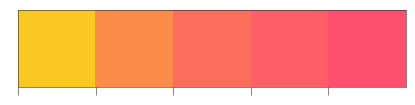

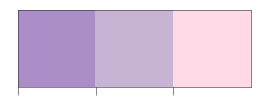

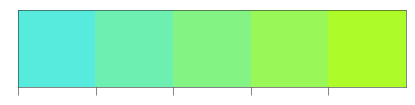

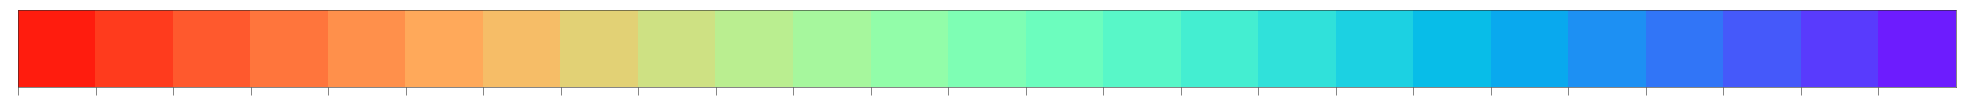

In [23]:
pam_palette = ["#F9C823", "#FB8C49", "#FC6E5C", "#FC5F65", "#FC506E"]
sns.palplot(pam_palette)

dir_palette = ["#ab8dc7", "#c7b4d4", "#ffd9e6"]
sns.palplot(dir_palette)

donor_length_palette = ["#57EBDE", "#6DEFB1", "#83F384", "#99F757", "#AEFB2A"]
sns.palplot(donor_length_palette)

chassis_palette = sns.color_palette("rainbow_r", 25)
sns.palplot(chassis_palette)

In [27]:
site1_forward_norm["site"] = 1
site2_forward_norm["site"] = 2
site3_forward_norm["site"] = 3
all_sites_forward_norm = pd.concat([site1_forward_norm,
                                    site2_forward_norm,
                                    site3_forward_norm])

site1_f_median["site"] = 1
site2_f_median["site"] = 2
site3_f_median["site"] = 3
all_sites_f_median = pd.concat([site1_f_median,
                                site2_f_median,
                                site3_f_median])

site1_donor_dir_working_pivot_matched["site"] = 1
site2_donor_dir_working_pivot_matched["site"] = 2
site3_donor_dir_working_pivot_matched["site"] = 3
all_sites_dir_pct_working = pd.concat([site1_donor_dir_working_pivot_matched,
                                   site2_donor_dir_working_pivot_matched,
                                   site3_donor_dir_working_pivot_matched])
all_sites_dir_pct_working["barcode_rep_matched"] = 100.0*all_sites_dir_pct_working["barcode_rep_matched"]

R_forward_norm = all_sites_forward_norm.loc[all_sites_forward_norm["donor_direction"] == "R", :]
R_forward_norm["norm_matched_barcode_rep"] = R_forward_norm["norm_matched_barcode_rep"].copy().astype("float")

/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Fig 3d-e:

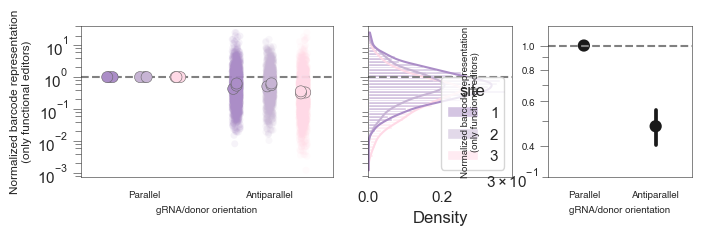

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20*cm, 5*cm), gridspec_kw={'width_ratios': [1.75, 1, 1]})

sns.stripplot(data=all_sites_forward_norm, x="donor_direction", y="norm_matched_barcode_rep",
              hue="site", dodge=True, palette=dir_palette, alpha=0.1, ax=ax[0], hue_order = [1, 2, 3])
sns.stripplot(data=all_sites_f_median, x="donor_direction", y="norm_matched_barcode_rep",
              hue="site", s=8, ax=ax[0], dodge=True, hue_order = [1, 2, 3],
              palette=dir_palette, edgecolor="gray", linewidth=0.4)
ax[0].set_yscale("log")
ax[0].axhline(1, color="gray", ls="--")
ax[0].set_ylabel("Normalized barcode representation\n(only functional editors)",
                 fontsize=8.5, font="Helvetica")
ax[0].get_legend().remove()
ax[0].set_xticklabels(["Parallel", "Antiparallel"], fontsize=7, font="Helvetica")
ax[0].set_xlabel("gRNA/donor orientation", fontsize=7, font="Helvetica", weight="bold")
ax[0].set_yticks([8*10**-4, 2*10**-3, 4*10**-3, 6*10**-3, 8*10**-3,
                 2*10**-2, 4*10**-2, 6*10**-2, 8*10**-2,
                 2*10**-1, 4*10**-1, 6*10**-1, 8*10**-1,
                 2*10**-0, 4*10**-0, 6*10**-0, 8*10**-0,
                 2*10, 4*10], minor=True)
ax[0].set_yticks([10**-3, 10**-2, 10**-1, 10**0, 10], major=True)
ax[0].tick_params(bottom = False)

# ax[1].set_yticklabels(labels=[10**-3, 10**-2, 10**-1, 10**0, 10**1], fontsize=6, font="Helvetica")
sns.histplot(data=R_forward_norm, y="norm_matched_barcode_rep", hue="site",
             palette=dir_palette[0:3], ax=ax[1], log_scale=True, stat="density", kde=True)
ax[1].axhline(1, color="gray", ls="--")
ax[1].set_ylabel("")
ax[1].set_yticks([8*10**-4, 2*10**-3, 4*10**-3, 6*10**-3, 8*10**-3,
                 2*10**-2, 4*10**-2, 6*10**-2, 8*10**-2,
                 2*10**-1, 4*10**-1, 6*10**-1, 8*10**-1,
                 2*10**-0, 4*10**-0, 6*10**-0, 8*10**-0,
                 2*10, 4*10], minor=True)
ax[1].set_yticklabels([])
ax[1].tick_params(bottom = False)

ax[2].set_clip_on(False)
sns.pointplot(data=all_sites_f_median,
              x="donor_direction",
              y="norm_matched_barcode_rep",
              color="k",
              s=5,
              ax=ax[2],
              order=["F", "R"],
              errorbar="sd",
              join=False)
ax[2].set_yscale("log")
ax[2].axhline(1, color="gray", ls="--")
ax[2].set_ylabel("Normalized barcode representation\n(only functional editors)",
                 fontsize=7,
                 font="Helvetica",
                 weight="bold")
ax[2].tick_params(axis='both', which='major', labelsize=7)
ax[2].set_xlabel("gRNA/donor orientation", fontsize=7, font="Helvetica", weight="bold")
ax[2].set_ylim([0.3, 1.2])
ax[2].set_xticklabels(["Parallel", "Antiparallel"], fontsize=7, font="Helvetica")
ax[2].tick_params(bottom = False)
ax[2].set_yticks([0.4, 0.6, 0.8, 1])
ax[2].set_yticklabels([0.4, 0.6, 0.8, 1.0], fontsize=7, font="Helvetica")
pass
# plt.savefig("PUB_direction_schematic_4.svg", transparent=True, bbox_inches="tight")

## Fig 3e statistics:

In [53]:
data_groups = [
    all_sites_f_median.loc[all_sites_f_median["donor_direction"] == "R", "norm_matched_barcode_rep"].values]

popmean = 1.0

t_stats = []
p_values = []

for data in data_groups:
    t_stat, p_value = stats.ttest_1samp(data, popmean)
    t_stats.append(t_stat)
    p_values.append(p_value)
    
# Adjust p-values for multiple comparisons using the Benjamini/Hochberg method
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print the results
for i, (t_stat, p_value, pval_corr, rej) in enumerate(zip(t_stats, p_values, pvals_corrected, reject)):
    print(f"Group {i+1}:")
    print(f"  t-statistic: {t_stat}")
    print(f"  Uncorrected p-value: {p_value}")
    print(f"  Corrected p-value: {pval_corr}")
    print(f"  Reject null hypothesis: {rej}")
    print()

Group 1:
  t-statistic: -12.461771867236067
  Uncorrected p-value: 1.606983698929925e-06
  Corrected p-value: 1.606983698929925e-06
  Reject null hypothesis: True



## Fig 3f-h

In [30]:
site1_length_norm["site"] = 1
site2_length_norm["site"] = 2
site3_length_norm["site"] = 3
all_sites_length_norm = pd.concat([site1_length_norm,
                                    site2_length_norm,
                                    site3_length_norm])

site1_length_median["site"] = 1
site2_length_median["site"] = 2
site3_length_median["site"] = 3
all_sites_length_median = pd.concat([site1_length_median,
                                site2_length_median,
                                site3_length_median])

site1_donor_length_working_pivot_matched["site"] = 1
site2_donor_length_working_pivot_matched["site"] = 2
site3_donor_length_working_pivot_matched["site"] = 3
all_sites_length_pct_working = pd.concat([site1_donor_length_working_pivot_matched,
                                   site2_donor_length_working_pivot_matched,
                                   site3_donor_length_working_pivot_matched])
all_sites_length_pct_working["barcode_rep_matched"] = 100.0*all_sites_length_pct_working["barcode_rep_matched"]

site1_pam_norm["site"] = 1
site2_pam_norm["site"] = 2
site3_pam_norm["site"] = 3
all_sites_pam_norm = pd.concat([site1_pam_norm,
                                    site2_pam_norm,
                                    site3_pam_norm])

site1_pam_median["site"] = 1
site2_pam_median["site"] = 2
site3_pam_median["site"] = 3
all_sites_pam_median = pd.concat([site1_pam_median,
                                site2_pam_median,
                                site3_pam_median])

site1_pam_pos_working_pivot_matched["site"] = 1
site2_pam_pos_working_pivot_matched["site"] = 2
site3_pam_pos_working_pivot_matched["site"] = 3
all_sites_pam_pos_pct_working = pd.concat([site1_pam_pos_working_pivot_matched,
                                   site2_pam_pos_working_pivot_matched,
                                   site3_pam_pos_working_pivot_matched])
all_sites_pam_pos_pct_working["barcode_rep_matched"] = 100.0*all_sites_pam_pos_pct_working["barcode_rep_matched"]

In [32]:
def normalize_donor_center(group_df):
    # dataframe passed by .apply should have columns:
    # rep
    # donor_direction
    # barcode_rep_matched --> only implementing matched rn
    # barcode_rep_raw
    # only computes mean of working values
    norm_PAM_pos = -3
    norm_center = 0
    if (norm_PAM_pos in group_df["PAM_position"].values) & (norm_center in group_df["donor_center"].values):
        if bool(set(group_df.loc[group_df["PAM_position"] == norm_PAM_pos, :].index) &\
                set(group_df.loc[group_df["donor_center"] == norm_center, :].index)):
            norm = group_df.loc[(group_df["PAM_position"] == norm_PAM_pos) &\
                                (group_df["donor_center"] == norm_center), "barcode_rep_matched"].values[0]
            if len(group_df) == 1:
                return None
            output_df = group_df.copy()
#             display(group_df)
            output_df["norm_matched_barcode_rep"] = group_df["barcode_rep_matched"]/norm
            return output_df
    else:
        return None

In [92]:
site1_center_norm = site1_only_working.groupby(["chassis_number",
                                                 "donor_direction",
                                                 "donor_length",
                                                 "rep"])[["barcode_rep_matched",
                                                          "donor_center",
                                                          "PAM_position"]].apply(normalize_donor_center).dropna().reset_index()
site1_lengths = {k: v for k, v in site1_center_norm.groupby("donor_length")}
for key in site1_lengths.keys():
    length_df = site1_lengths[key]
    rep_df = length_df.groupby(["rep",
                                "donor_center",
                                "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()
    site1_lengths[key] = rep_df.groupby(["donor_center",
                                         "PAM_position"]).mean().drop(columns="rep")
    
site2_center_norm = site2_only_working.groupby(["chassis_number",
                                                 "donor_direction",
                                                 "donor_length",
                                                 "rep"])[["barcode_rep_matched",
                                                          "donor_center",
                                                          "PAM_position"]].apply(normalize_donor_center).dropna().reset_index()
site2_lengths = {k: v for k, v in site2_center_norm.groupby("donor_length")}
for key in site2_lengths.keys():
    length_df = site2_lengths[key]
    rep_df = length_df.groupby(["rep",
                                "donor_center",
                                "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()
    site2_lengths[key] = rep_df.groupby(["donor_center",
                                         "PAM_position"]).mean().drop(columns="rep")

    
site3_center_norm = site3_only_working.groupby(["chassis_number",
                                                 "donor_direction",
                                                 "donor_length",
                                                 "rep"])[["barcode_rep_matched",
                                                          "donor_center",
                                                          "PAM_position"]].apply(normalize_donor_center).dropna().reset_index()
site3_lengths = {k: v for k, v in site3_center_norm.groupby("donor_length")}
for key in site3_lengths.keys():
    length_df = site3_lengths[key]
    rep_df = length_df.groupby(["rep",
                                "donor_center",
                                "PAM_position"])["norm_matched_barcode_rep"].median().reset_index()
    site3_lengths[key] = rep_df.groupby(["donor_center",
                                         "PAM_position"]).mean().drop(columns="rep")

# now let's average the sites
heatmap_data = {}
for key in site1_lengths.keys():
    s1_df = site1_lengths[key]
    s2_df = site2_lengths[key]
    s3_df = site3_lengths[key]
    all_reps_length = s3_df.join(s2_df, how="outer",
                                 lsuffix="_S3", rsuffix = "_S2")
    all_reps_length = all_reps_length.join(s1_df, how="outer")
    all_reps_length_melted = all_reps_length.mean(axis='columns').to_frame().rename(columns={0: "barcode_rep_matched_norm"})
    heatmap_data[key] = pd.pivot_table(data=all_reps_length_melted,
                                       index=["donor_center", "PAM_position"],
                                       values="barcode_rep_matched_norm").unstack(level=0)

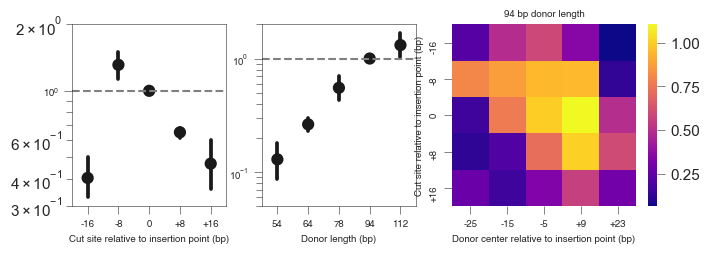

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20*cm, 6*cm), gridspec_kw={'width_ratios': [1, 1, 1.5]})

# pam position
ax[0].set_clip_on(False)
sns.pointplot(data=all_sites_pam_median,
              x="PAM_position",
              y="norm_matched_barcode_rep",
              color="k",
              s=5,
              ax=ax[0],
              hue_order=[-13.0, -5.0, -3.0, 11.0, 19.0],
              errorbar="sd",
              join=False)
ax[0].set_ylim([0.3, 2.0])
ax[0].set_yticks([0.4, 0.6, 0.8, 1.0, 2.0])
ax[0].set_yticklabels([0.4, 0.6, 0.8, 1.0, 2.0], font="Helvetica", fontsize=7)
ax[0].set_yscale("log")
ax[0].axhline(1, color="gray", ls="--")
ax[0].set_ylabel("")
ax[0].tick_params(axis='both', which='major', labelsize=7)
ax[0].set_xlabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica", weight="bold")
ax[0].set_xticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")

# donor length
ax[2].set_clip_on(False)
sns.pointplot(data=all_sites_length_median,
              x="donor_length",
              y="norm_matched_barcode_rep",
              color="k",
              s=5,
              ax=ax[1],
              order=[54.0, 64.0, 78.0, 94.0, 112.0],
              errorbar="sd",
              join=False)
ax[1].set_ylim([0.05, 2])
ax[1].set_yscale("log")
ax[1].axhline(1, color="gray", ls="--")
ax[1].set_ylabel("",
                 fontsize=12)
ax[1].set_xlabel("Donor length (bp)", fontsize=7, font="Helvetica")
ax[1].tick_params(axis='both', which='major', labelsize=7)
ax[1].set_xticklabels([54, 64, 78, 94, 112], fontsize=7, font="Helvetica")

length_data = heatmap_data[94]
sns.heatmap(length_data.droplevel(0, axis=1), ax=ax[2],
            cbar_kws={"label": None}, cmap="plasma", clip_on=False)
ax[2].set_title("94 bp donor length", fontsize=7, font="Helvetica")
ax[2].set_ylabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica")
ax[2].set_yticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")
ax[2].set_xlabel("Donor center relative to insertion point (bp)",
                 fontsize=7, font="Helvetica")
ax[2].set_xticklabels(["-25", "-15", "-5", "+9", "+23"], fontsize=7, font="Helvetica")
plt.yticks(fontsize=7)
pass
# plt.savefig("PUB_dir_pam_length_donor_center_3.svg", transparent=True, bbox_inches="tight")

## Fig 3f-h statistics:
- Fig 3f: one-sample t-test comparing to a population mean of 1.0, correcting for multiple comparisons with bonferroni
- Fig 3g: one-sample t-test comparing to a population mean of 1.0, correcting for multiple comparisons with bonferroni
- Fig 3h: two-way ANOVA with no follow-up --> is there an interaction between donor center and cut site on editing efficiency?

In [56]:
# Fig 3f:
data_groups = [
    all_sites_pam_median.loc[all_sites_pam_median["PAM_position"] == -13.0, "norm_matched_barcode_rep"].values,
    all_sites_pam_median.loc[all_sites_pam_median["PAM_position"] == -5.0, "norm_matched_barcode_rep"].values,
    all_sites_pam_median.loc[all_sites_pam_median["PAM_position"] == 11.0, "norm_matched_barcode_rep"].values,
    all_sites_pam_median.loc[all_sites_pam_median["PAM_position"] == 19.0, "norm_matched_barcode_rep"].values]

popmean = 1.0

t_stats = []
p_values = []

for data in data_groups:
    t_stat, p_value = stats.ttest_1samp(data, popmean)
    t_stats.append(t_stat)
    p_values.append(p_value)
    
# Adjust p-values for multiple comparisons using the Benjamini/Hochberg method
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print the results
for i, (t_stat, p_value, pval_corr, rej) in enumerate(zip(t_stats, p_values, pvals_corrected, reject)):
    print(f"Group {i+1}:")
    print(f"  t-statistic: {t_stat}")
    print(f"  Uncorrected p-value: {p_value}")
    print(f"  Corrected p-value: {pval_corr}")
    print(f"  Reject null hypothesis: {rej}")
    print()

Group 1:
  t-statistic: -12.666779429077785
  Uncorrected p-value: 1.4183500677413784e-06
  Corrected p-value: 5.6734002709655135e-06
  Reject null hypothesis: True

Group 2:
  t-statistic: 2.8527846662213756
  Uncorrected p-value: 0.03570698979040458
  Corrected p-value: 0.1428279591616183
  Reject null hypothesis: False

Group 3:
  t-statistic: -20.471493703754998
  Uncorrected p-value: 3.391977514612827e-08
  Corrected p-value: 1.3567910058451308e-07
  Reject null hypothesis: True

Group 4:
  t-statistic: -8.118655329174157
  Uncorrected p-value: 3.927098358683538e-05
  Corrected p-value: 0.00015708393434734152
  Reject null hypothesis: True



In [57]:
# Fig 3g:
data_groups = [
    all_sites_length_median.loc[all_sites_length_median["donor_length"] == 54.0, "norm_matched_barcode_rep"].values,
    all_sites_length_median.loc[all_sites_length_median["donor_length"] == 64.0, "norm_matched_barcode_rep"].values,
    all_sites_length_median.loc[all_sites_length_median["donor_length"] == 78.0, "norm_matched_barcode_rep"].values,
    all_sites_length_median.loc[all_sites_length_median["donor_length"] == 112.0, "norm_matched_barcode_rep"].values]

popmean = 1.0

t_stats = []
p_values = []

for data in data_groups:
    t_stat, p_value = stats.ttest_1samp(data, popmean)
    t_stats.append(t_stat)
    p_values.append(p_value)
    
# Adjust p-values for multiple comparisons using the Benjamini/Hochberg method
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print the results
for i, (t_stat, p_value, pval_corr, rej) in enumerate(zip(t_stats, p_values, pvals_corrected, reject)):
    print(f"Group {i+1}:")
    print(f"  t-statistic: {t_stat}")
    print(f"  Uncorrected p-value: {p_value}")
    print(f"  Corrected p-value: {pval_corr}")
    print(f"  Reject null hypothesis: {rej}")
    print()

Group 1:
  t-statistic: -33.76426220748118
  Uncorrected p-value: 6.465858280614042e-10
  Corrected p-value: 2.5863433122456167e-09
  Reject null hypothesis: True

Group 2:
  t-statistic: -39.49329476970047
  Uncorrected p-value: 1.857941610909704e-10
  Corrected p-value: 7.431766443638816e-10
  Reject null hypothesis: True

Group 3:
  t-statistic: -5.705916442791926
  Uncorrected p-value: 0.0004512920672047479
  Corrected p-value: 0.0018051682688189916
  Reject null hypothesis: True

Group 4:
  t-statistic: 1.7791654851825112
  Uncorrected p-value: 0.11309436057046315
  Corrected p-value: 0.4523774422818526
  Reject null hypothesis: False



In [114]:
s1_medians_per_rep = site1_center_norm.loc[site1_center_norm["donor_length"] == 94.0, :].\
                     groupby(["rep",
                              "donor_center",
                              "PAM_position"])[["norm_matched_barcode_rep"]].median()
s2_medians_per_rep = site2_center_norm.loc[site2_center_norm["donor_length"] == 94.0, :].\
                     groupby(["rep",
                              "donor_center",
                              "PAM_position"])[["norm_matched_barcode_rep"]].median()
s3_medians_per_rep = site3_center_norm.loc[site3_center_norm["donor_length"] == 94.0, :].\
                     groupby(["rep",
                              "donor_center",
                              "PAM_position"])[["norm_matched_barcode_rep"]].median()


medians_per_rep = s1_medians_per_rep.join(s2_medians_per_rep, how="outer", lsuffix="_S1", rsuffix="_S2")
medians_per_rep = medians_per_rep.join(s3_medians_per_rep, how="outer", rsuffix="_S3")
anova_df = medians_per_rep.reset_index().melt(id_vars=["donor_center", "PAM_position"],
                                              value_vars=["norm_matched_barcode_rep_S1",
                                                          "norm_matched_barcode_rep_S2",
                                                          "norm_matched_barcode_rep"]).drop("variable", axis=1)

In [118]:
model = ols('value ~ C(donor_center) + C(PAM_position) + C(donor_center):C(PAM_position)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                    sum_sq     df          F        PR(>F)
C(donor_center)                   8.828166    4.0  18.411484  6.759328e-13
C(PAM_position)                   6.888093    4.0  14.365386  2.508783e-10
C(donor_center):C(PAM_position)   7.873764   16.0   4.105260  8.570908e-07
Residual                         23.974617  200.0        NaN           NaN


## Fig 3i

In [38]:
site1_chassis_norm["site"] = 1
site2_chassis_norm["site"] = 2
site3_chassis_norm["site"] = 3
all_sites_chassis_norm = pd.concat([site1_chassis_norm,
                                    site2_chassis_norm,
                                    site3_chassis_norm])

site1_chassis_median["site"] = 1
site2_chassis_median["site"] = 2
site3_chassis_median["site"] = 3
all_sites_chassis_median = pd.concat([site1_chassis_median,
                                site2_chassis_median,
                                site3_chassis_median])

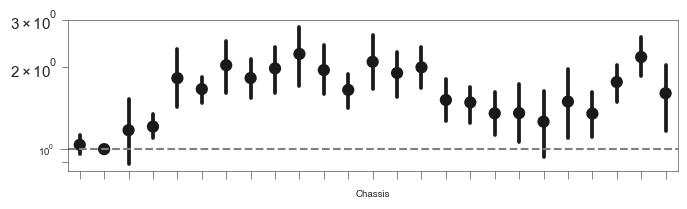

In [42]:
fig, ax = plt.subplots(figsize=(20*cm, 5*cm))


ax.set_clip_on(False)
sns.pointplot(data=all_sites_chassis_median,
              x="chassis_number",
              y="norm_matched_barcode_rep",
              color="k",
              s=5,
              ax=ax,
              order=[1, 2, 6, 5, 4, 3, 22, 23, 24, 25, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
              errorbar="sd",
              join=False)
# ax.set_ylim([0.05, 2])
ax.set_yscale("log")
ax.axhline(1, color="gray", ls="--")
ax.set_ylabel("",
                 fontsize=12)
ax.set_xlabel("Chassis", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticklabels([], fontsize=7, font="Helvetica")
pass

## Fig 3i statistics:

In [120]:
data_groups = [
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 1, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 6, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 5, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 4, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 3, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 22, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 23, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 24, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 25, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 7, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 8, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 9, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 10, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 11, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 12, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 13, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 14, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 15, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 16, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 17, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 18, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 19, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 20, "norm_matched_barcode_rep"].values,
    all_sites_chassis_median.loc[all_sites_chassis_median["chassis_number"] == 21, "norm_matched_barcode_rep"].values]

popmean = 1.0

t_stats = []
p_values = []

for data in data_groups:
    t_stat, p_value = stats.ttest_1samp(data, popmean)
    t_stats.append(t_stat)
    p_values.append(p_value)
    
# Adjust p-values for multiple comparisons using the bonferroni
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print the results
for i, (t_stat, p_value, pval_corr, rej) in enumerate(zip(t_stats, p_values, pvals_corrected, reject)):
    print(f"Group {i+1}:")
    print(f"  t-statistic: {t_stat}")
    print(f"  Uncorrected p-value: {p_value}")
    print(f"  Corrected p-value: {pval_corr}")
    print(f"  Reject null hypothesis: {rej}")
    print()

Group 1:
  t-statistic: 0.7957498936996432
  Uncorrected p-value: 0.4491423052627699
  Corrected p-value: 1.0
  Reject null hypothesis: False

Group 2:
  t-statistic: 0.9522499954482472
  Uncorrected p-value: 0.36885063704874216
  Corrected p-value: 1.0
  Reject null hypothesis: False

Group 3:
  t-statistic: 3.0504785145026028
  Uncorrected p-value: 0.015809540869884665
  Corrected p-value: 0.379428980877232
  Reject null hypothesis: False

Group 4:
  t-statistic: 3.412118570200911
  Uncorrected p-value: 0.009194322374129862
  Corrected p-value: 0.22066373697911668
  Reject null hypothesis: False

Group 5:
  t-statistic: 6.690899708772304
  Uncorrected p-value: 0.000154146370815797
  Corrected p-value: 0.0036995128995791285
  Reject null hypothesis: True

Group 6:
  t-statistic: 4.044241758336964
  Uncorrected p-value: 0.003713792091350461
  Corrected p-value: 0.08913101019241107
  Reject null hypothesis: False

Group 7:
  t-statistic: 4.929793876105263
  Uncorrected p-value: 0.001149

# SUPPLEMENTAL:

# RANKING: DO THE BEST DONORS STAY THE BEST ACROSS REPS?

In [90]:
# redefining, in case I don't run the upper cells
site1_br_only = site1_barcode_rep.loc[:, (slice(None), 48, "barcode_rep_matched")]
site1_br_only.columns = site1_br_only.columns.droplevel(1)
site1_br_only.columns = site1_br_only.columns.droplevel(1)
site1_br_only["barcode_rep_mean"] = site1_br_only.mean(axis=1)
site1_br_only.dropna(subset=["barcode_rep_mean"], inplace=True)
# drop members that are only represented in 1 replicate:
site1_br_only.dropna(subset=[1, 2, 3], thresh=2, inplace=True)
site1_br_only = site1_br_only.sort_values(by="barcode_rep_mean", ascending=True).copy()
site1_br_only["ranking"] = np.linspace(1, len(site1_br_only), num=len(site1_br_only))

site2_br_only = site2_barcode_rep.loc[:, (slice(None), 48, "barcode_rep_matched")]
site2_br_only.columns = site2_br_only.columns.droplevel(1)
site2_br_only.columns = site2_br_only.columns.droplevel(1)
site2_br_only["barcode_rep_mean"] = site2_br_only.mean(axis=1)
site2_br_only.dropna(subset=["barcode_rep_mean"], inplace=True)
site2_br_only.dropna(subset=[1, 2, 3], thresh=2, inplace=True)
site2_br_only = site2_br_only.sort_values(by="barcode_rep_mean", ascending=True).copy()
site2_br_only["ranking"] = np.linspace(1, len(site2_br_only), num=len(site2_br_only))


site3_br_only = site3_barcode_rep.loc[:, (slice(None), 48, "barcode_rep_matched")]
site3_br_only.columns = site3_br_only.columns.droplevel(1)
site3_br_only.columns = site3_br_only.columns.droplevel(1)
site3_br_only["barcode_rep_mean"] = site3_br_only.mean(axis=1)
site3_br_only.dropna(subset=["barcode_rep_mean"], inplace=True)
site3_br_only.dropna(subset=[1, 2, 3], thresh=2, inplace=True)
site3_br_only = site3_br_only.sort_values(by="barcode_rep_mean", ascending=True).copy()
site3_br_only["ranking"] = np.linspace(1, len(site3_br_only), num=len(site3_br_only))

/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/katecrawford/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [24]:
site1_barcode_rep.loc[:, (slice(None), 48, "barcode_rep_matched")].head()

rep,1,2,3
timepoint,48,48,48
type,barcode_rep_matched,barcode_rep_matched,barcode_rep_matched
barcode,,,
AAAAACGCCG,7.084546,3.141536,NaN
AAAACGCGAC,0.000000,0.000000,NaN
AAAAGCGGCT,2.646973,4.134667,0.0
AAACACCTGC,NaN,NaN,NaN
AAACAGGCAC,0.679541,0.837378,0.0


In [141]:
site1_info_drop = site1_info.copy()
site1_info_drop.columns = site1_info.columns.droplevel(0)
site1_info_drop.columns = site1_info_drop.columns.droplevel(0)

# site1_info_drop = site1_info_drop.columns.droplevel(0)

site1_br_only_with_info = pd.merge(site1_br_only, site1_info_drop,
                                   how="left", left_index=True,
                                   right_index=True)
site1_norm_control = site1_br_only_with_info.loc[(site1_br_only_with_info["PAM_position"] == -3) &\
                                                 (site1_br_only_with_info["donor_length"] == 94) &\
                                                 (site1_br_only_with_info["donor_direction"] == "F") &\
                                                 (site1_br_only_with_info["donor_center"] == 0) &\
                                                 (site1_br_only_with_info["chassis_number"] == 3), : ]
display(site1_norm_control)

site2_info_drop = site2_info.copy()
site2_info_drop.columns = site2_info.columns.droplevel(0)
site2_info_drop.columns = site2_info_drop.columns.droplevel(0)

# site1_info_drop = site1_info_drop.columns.droplevel(0)

site2_br_only_with_info = pd.merge(site2_br_only, site2_info_drop,
                                   how="left", left_index=True,
                                   right_index=True)
site2_norm_control = site2_br_only_with_info.loc[(site2_br_only_with_info["PAM_position"] == -3) &\
                                                 (site2_br_only_with_info["donor_length"] == 94) &\
                                                 (site2_br_only_with_info["donor_direction"] == "F") &\
                                                 (site2_br_only_with_info["donor_center"] == 0) &\
                                                 (site2_br_only_with_info["chassis_number"] == 3), : ]
display(site2_norm_control)

site3_info_drop = site3_info.copy()
site3_info_drop.columns = site3_info.columns.droplevel(0)
site3_info_drop.columns = site3_info_drop.columns.droplevel(0)

# site1_info_drop = site1_info_drop.columns.droplevel(0)

site3_br_only_with_info = pd.merge(site3_br_only, site1_info_drop,
                                   how="left", left_index=True,
                                   right_index=True)
site3_norm_control = site3_br_only_with_info.loc[(site3_br_only_with_info["PAM_position"] == -3) &\
                                                 (site3_br_only_with_info["donor_length"] == 94) &\
                                                 (site3_br_only_with_info["donor_direction"] == "F") &\
                                                 (site3_br_only_with_info["donor_center"] == 0) &\
                                                 (site3_br_only_with_info["chassis_number"] == 3), : ]
display(site3_norm_control)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

Within a site, are the top ranked donors always the top ranked donors?

Reference donor: F, -3 PAM position, 94 bp donor length, donor center 0, chassis 3 (long primer CRISPEY)

In [26]:
site1_melt = site1_br_only_with_info.melt(id_vars=["ranking"], value_vars=[1, 2, 3])

Text(0.5, 1.0, 'site 3')

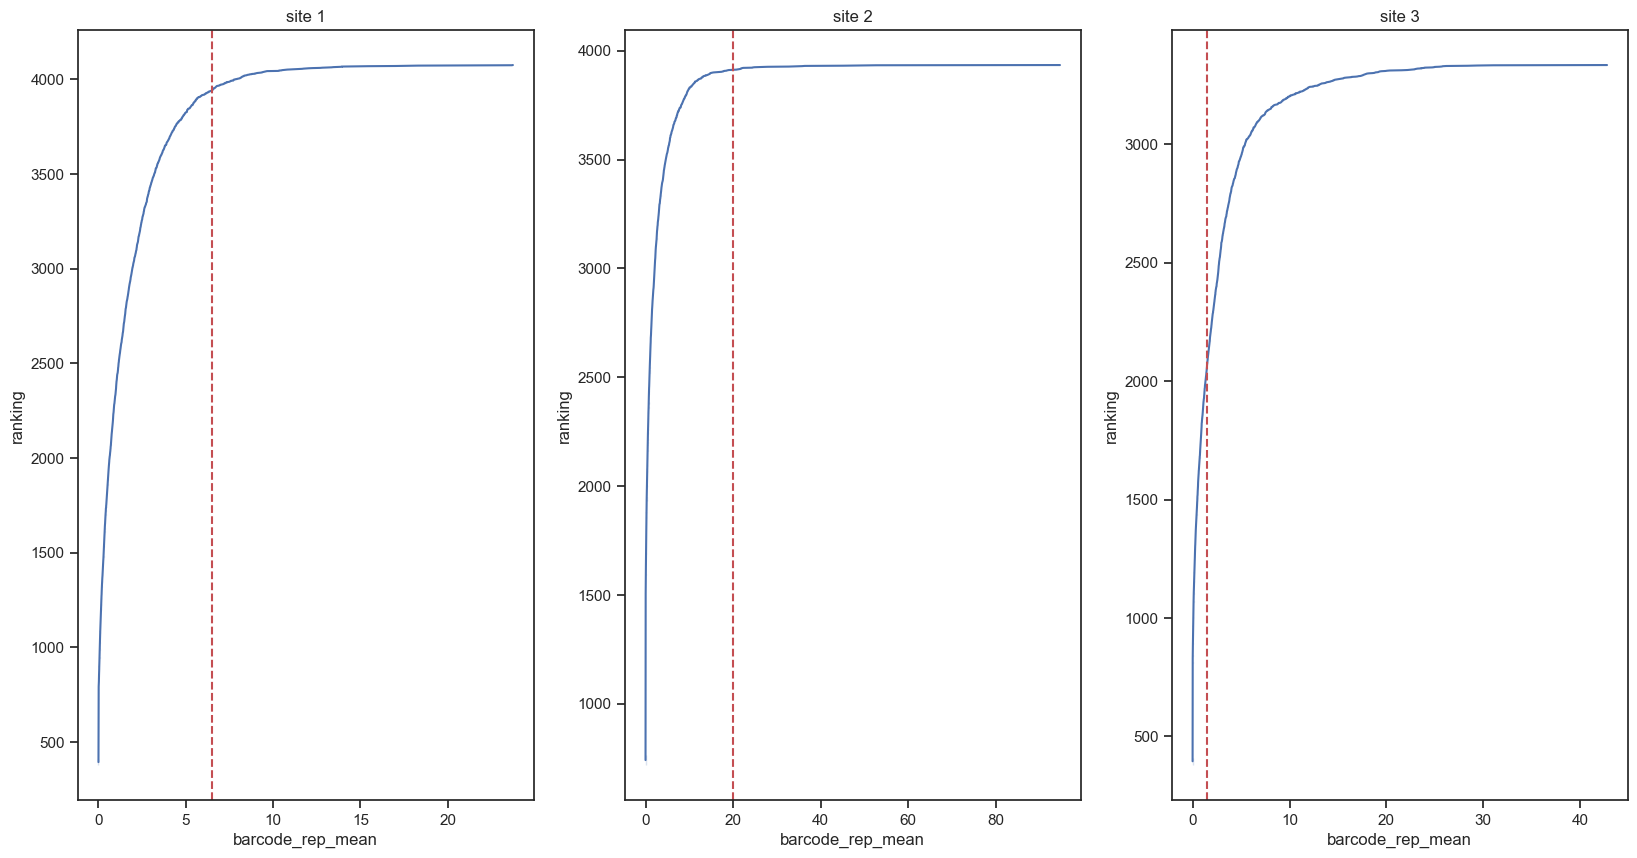

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))

sns.lineplot(data=site1_br_only, x="barcode_rep_mean", y="ranking", ax=ax[0])
ax[0].axvline(site1_norm_control["barcode_rep_mean"].values[0], color="r", ls="--")
# 4000 member stripplot apparently too computationally expensive
# sns.stripplot(data=site1_melt, x="value", y="ranking", ax=ax[0])
ax[0].set_title("site 1")

sns.lineplot(data=site2_br_only, x="barcode_rep_mean", y="ranking", ax=ax[1])
ax[1].axvline(site2_norm_control["barcode_rep_mean"].values[0], color="r", ls="--")
ax[1].set_title("site 2")

sns.lineplot(data=site3_br_only, x="barcode_rep_mean", y="ranking", ax=ax[2])
ax[2].axvline(site3_norm_control["barcode_rep_mean"].values[0], color="r", ls="--")
ax[2].set_title("site 3")

In [91]:
# how correlated are the rankings?
site1_br_only = site1_br_only.sort_values(by=1, ascending=True)
site1_br_only["ranking_rep1"] = np.linspace(1, len(site1_br_only), num=len(site1_br_only))
site1_br_only = site1_br_only.sort_values(by=2, ascending=True)
site1_br_only["ranking_rep2"] = np.linspace(1, len(site1_br_only), num=len(site1_br_only))
site1_br_only = site1_br_only.sort_values(by=3, ascending=True)
site1_br_only["ranking_rep3"] = np.linspace(1, len(site1_br_only), num=len(site1_br_only))
site1_br_only = site1_br_only.sort_values(by=1, ascending=True)

Text(0.5, 0.98, 'Rankings are somewhat correlated between replicates for a single site (1)')

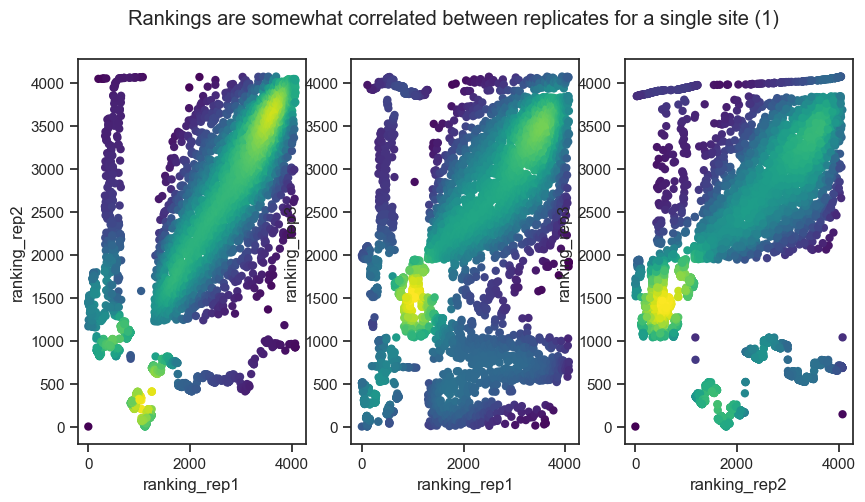

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

rep_dict = {0: ["ranking_rep1", "ranking_rep2"],
            1: ["ranking_rep1", "ranking_rep3"],
            2: ["ranking_rep2", "ranking_rep3"]}

for index in np.linspace(0, 2, 3):
    index = int(index)
    values = np.vstack([site1_br_only[rep_dict[index][0]] ,site1_br_only[rep_dict[index][1]]])
    kernel = stats.gaussian_kde(values)(values)
    sns.scatterplot(
        data=site1_br_only,
        x=rep_dict[index][0],
        y=rep_dict[index][1],
        c=kernel,
        cmap="viridis",
        ax=ax[index],
        linewidth=0,
    )
    
plt.suptitle("Rankings are somewhat correlated between replicates for a single site (1)")

What are ranking correlations ACROSS sites?

The barcodes ARE NOT the same donor-chassis combination across the sites. Makes life very hard. Have altered the code above to deal with it (now "UMI" contains an index that can be matched across info dataframes)

In [76]:
site1_br_only

rep,1,2,3,barcode_rep_mean,ranking,ranking_rep1,ranking_rep2,ranking_rep3
barcode,,,,,,,,
ACTTCCTGGG,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
CTCCCACTAG,0.0,0.000000,0.000000,0.000000,485.0,1204.0,120.0,1193.0
TTGCCCTACA,0.0,0.000000,0.000000,0.000000,501.0,1205.0,119.0,1192.0
CCATGGCAAG,0.0,0.000000,0.000000,0.000000,690.0,224.0,841.0,1191.0
CGATGGCCTA,0.0,0.000000,0.000000,0.000000,562.0,1206.0,118.0,1190.0
...,...,...,...,...,...,...,...,...
GTGGGTAGAC,NaN,0.000000,0.000000,0.000000,98.0,4067.0,922.0,1918.0
TCCTTGTACG,NaN,13.194453,3.503883,8.349168,4019.0,4074.0,4030.0,3406.0
CACGACGATA,NaN,0.000000,4.570283,2.285141,3163.0,4070.0,927.0,3555.0


In [101]:
site1_br_only_umi = pd.concat([site1_br_only[["barcode_rep_mean", "ranking"]],
                           site1_info[["UMI"]]], axis=1, join="inner").\
                           set_index("UMI").rename(columns={"ranking": "site1_ranking",
                                                            "barcode_rep_mean": "br_mean_site1"})
site2_br_only_umi = pd.concat([site2_br_only[["barcode_rep_mean", "ranking"]],
                           site2_info[["UMI"]]], axis=1, join="inner").\
                           set_index("UMI").rename(columns={"ranking": "site2_ranking",
                                                            "barcode_rep_mean": "br_mean_site2"})
site3_br_only_umi = pd.concat([site3_br_only[["barcode_rep_mean", "ranking"]],
                           site3_info[["UMI"]]], axis=1, join="inner").\
                           set_index("UMI").rename(columns={"ranking": "site3_ranking",
                                                            "barcode_rep_mean": "br_mean_site3"})

In [124]:
full_br_ranking = pd.concat([site1_br_only_umi,
                             site2_br_only_umi,
                             site3_br_only_umi],
                             axis=1, join="inner")

In [120]:
full_br_ranking

,br_mean_site1,site1_ranking,br_mean_site2,site2_ranking,br_mean_site3,site3_ranking
UMI,,,,,,
0.0,0.693071,2053.0,0.000000,557.0,2.154298,2303.0
1.0,0.653168,2014.0,0.000000,954.0,3.030545,2592.0
2.0,1.784237,2920.0,2.908887,3230.0,NaN,NaN
3.0,4.190451,3717.0,1.833292,2909.0,NaN,NaN
4.0,2.614698,3311.0,0.975171,2552.0,1.059573,1874.0
...,...,...,...,...,...,...
4270.0,0.000000,186.0,0.000000,501.0,0.000000,764.0
4271.0,0.197800,1325.0,0.000000,1465.0,0.000000,68.0
4272.0,0.000000,27.0,0.000000,437.0,NaN,NaN


In [125]:
site1_info.loc[(site1_info["PAM_position"] == -3) &\
               (site1_info["donor_length"] == 94) &\
               (site1_info["donor_direction"] == "F") &\
               (site1_info["donor_center"] == 0) &\
               (site1_info["chassis_number"] == 3)]

,PAM_position,donor_length,donor_direction,donor_center,chassis_number,UMI
barcode,,,,,,
TATCCCCTCT,-3.0,94.0,F,0.0,3.0,1917.0


In [154]:
full_br_ranking.loc[1917.0, :]

br_mean_site1       6.530227
site1_ranking    3943.000000
br_mean_site2      19.949415
site2_ranking    3912.000000
br_mean_site3       4.649182
site3_ranking    2903.000000
Name: 1917.0, dtype: float64

Text(0.5, 0.98, 'Rankings are correlated between sites')

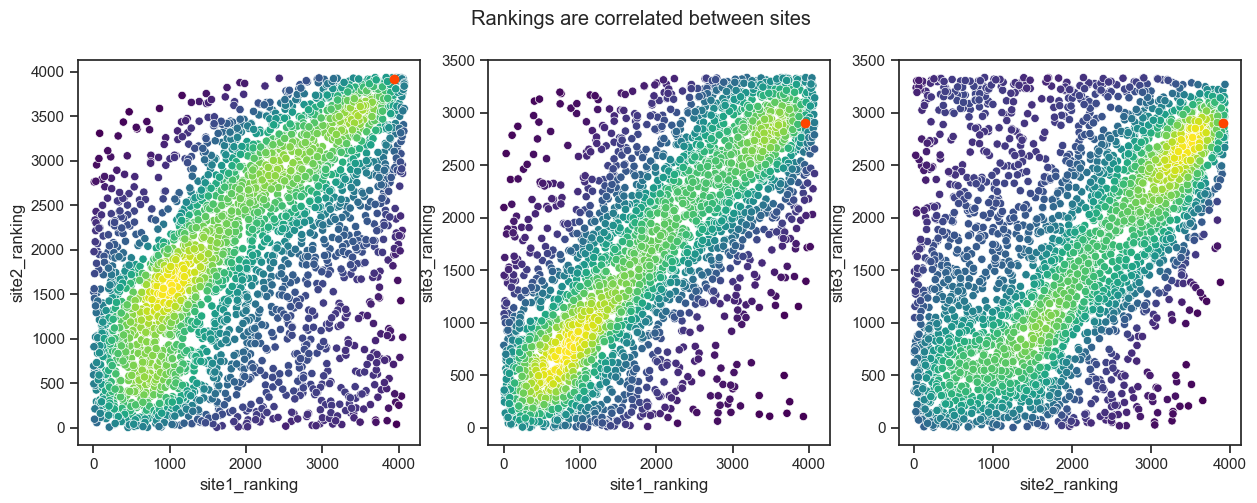

In [138]:
# lets highlight the "normalization" design
norm_umi = 1916
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rep_dict = {0: ["site1_ranking", "site2_ranking"],
            1: ["site1_ranking", "site3_ranking"],
            2: ["site2_ranking", "site3_ranking"]}

for index in np.linspace(0, 2, 3):
    index = int(index)
    values = np.vstack([full_br_ranking[rep_dict[index][0]] ,full_br_ranking[rep_dict[index][1]]])
    kernel = stats.gaussian_kde(values)(values)
    sns.scatterplot(
        data=full_br_ranking,
        x=rep_dict[index][0],
        y=rep_dict[index][1],
        c=kernel,
        cmap="viridis",
        ax=ax[index],
    )
    ax[index].plot(full_br_ranking.loc[1917, rep_dict[index][0]],
                   full_br_ranking.loc[1917, rep_dict[index][1]],
                   c="orangered", marker="o")
    
plt.suptitle("Rankings are correlated between sites")

What are the composition of the top-ranked donors? Does the donor length always stay long, for example?

In [139]:
# pull out donors that are better than the reference standard
site1_better_than_ref = site1_br_only_with_info.loc[site1_br_only_with_info["barcode_rep_mean"] >\
                                                    site1_norm_control["barcode_rep_mean"].values[0], :]
site2_better_than_ref = site2_br_only_with_info.loc[site2_br_only_with_info["barcode_rep_mean"] >\
                                          site2_norm_control["barcode_rep_mean"].values[0], :]
site3_better_than_ref = site3_br_only_with_info.loc[site3_br_only_with_info["barcode_rep_mean"] >\
                                          site3_norm_control["barcode_rep_mean"].values[0], :]

In [158]:
# add UMI onto this information
site1_better_than_ref_umi = pd.concat([site1_better_than_ref, site1_info[["UMI"]]], axis=1, join="inner")
site2_better_than_ref_umi = pd.concat([site2_better_than_ref, site2_info[["UMI"]]], axis=1, join="inner")
site3_better_than_ref_umi = pd.concat([site3_better_than_ref, site3_info[["UMI"]]], axis=1, join="inner")

In [159]:
s1 = set(site1_better_than_ref_umi["UMI"])
s2 = set(site2_better_than_ref_umi["UMI"])
s3 = set(site3_better_than_ref_umi["UMI"])

# Calculates intersection of
# sets on s1 and s2
set1 = s1.intersection(s2)

# Calculates intersection of sets
# on set1 and s3
result_set = set1.intersection(s3)
result_set

{1755.0, 1922.0, 1936.0, 1937.0, 1968.0, 2143.0}

In [165]:
site1_info.loc[(site1_info["UMI"] == 1755) |\
               (site1_info["UMI"] == 1922.0) |\
               (site1_info["UMI"] == 1936.0) |\
               (site1_info["UMI"] == 1937.0) |\
               (site1_info["UMI"] == 1968.0) |\
               (site1_info["UMI"] == 2143.0), :]

,PAM_position,donor_length,donor_direction,donor_center,chassis_number,UMI
barcode,,,,,,
GGTCGAGATC,-3.0,112.0,F,0.0,4.0,1755.0
ATGGAGGGCA,-3.0,94.0,F,0.0,8.0,1922.0
ATTCAAGGCG,-3.0,94.0,F,0.0,22.0,1936.0
ACGTACACCA,-3.0,94.0,F,0.0,23.0,1937.0
ATCGCCGTTA,-3.0,94.0,F,14.0,4.0,1968.0
CTTGCCCAAC,-3.0,78.0,F,10.0,4.0,2143.0


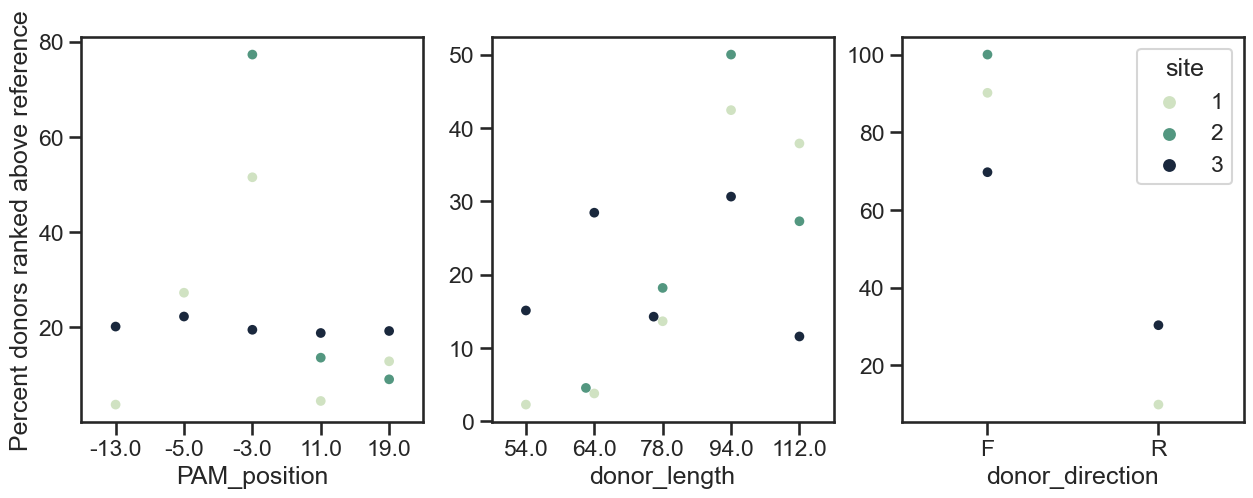

In [294]:
axes = ["PAM_position", "donor_length", "donor_direction"]
palette = sns.cubehelix_palette(3, rot=-.5)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for index, variable in enumerate(axes):
    site1_groupby = site1_better_than_ref.groupby(variable)["ranking"].count()
    site1_groupby = (100.0*site1_groupby/sum(site1_groupby)).to_frame()
    site1_groupby["site"] = 1
    
    site2_groupby = site2_better_than_ref.groupby(variable)["ranking"].count()
    site2_groupby = (100.0*site2_groupby/sum(site2_groupby)).to_frame()
    site2_groupby["site"] = 2

    site3_groupby = site3_better_than_ref.groupby(variable)["ranking"].count()
    site3_groupby = (100.0*site3_groupby/sum(site3_groupby)).to_frame()
    site3_groupby["site"] = 3

    full_var_df = site1_groupby.append(site2_groupby)
    full_var_df = full_var_df.append(site3_groupby).reset_index()
    sns.swarmplot(data=full_var_df, x=variable, y="ranking", hue="site", ax=ax[index], palette=palette, s=7)
    ax[index].set_ylabel(None)

ax[0].set_ylabel("Percent donors ranked above reference")
ax[0].get_legend().remove()
ax[1].get_legend().remove()

# notes: only consider donor lengths with both fow & rev for the donor direction plot

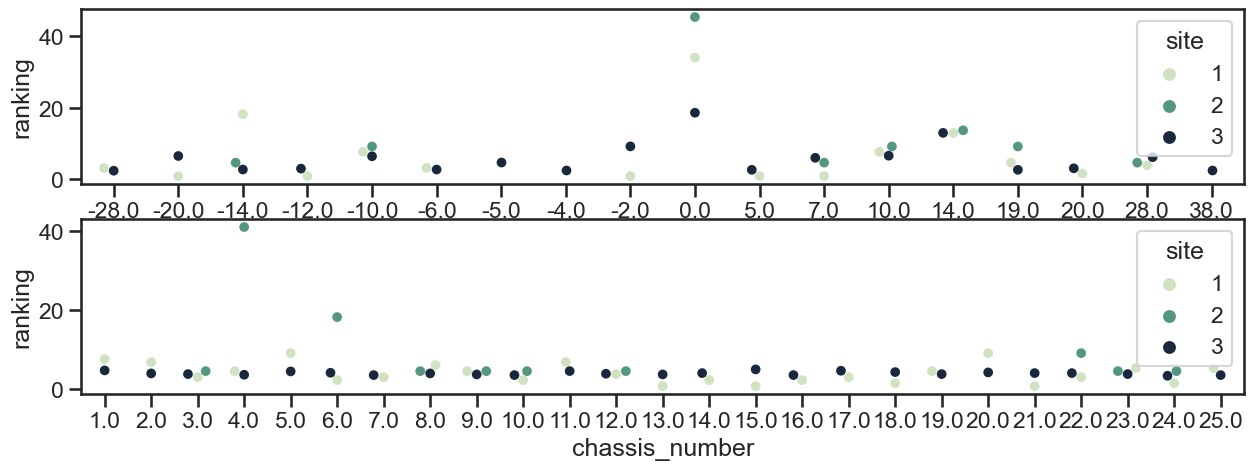

In [297]:
axes = ["donor_center", "chassis_number"]

palette = sns.cubehelix_palette(3, rot=-.5)

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
for index, variable in enumerate(axes):
    site1_groupby = site1_better_than_ref.groupby(variable)["ranking"].count()
    site1_groupby = (100.0*site1_groupby/sum(site1_groupby)).to_frame()
    site1_groupby["site"] = 1
    
    site2_groupby = site2_better_than_ref.groupby(variable)["ranking"].count()
    site2_groupby = (100.0*site2_groupby/sum(site2_groupby)).to_frame()
    site2_groupby["site"] = 2

    site3_groupby = site3_better_than_ref.groupby(variable)["ranking"].count()
    site3_groupby = (100.0*site3_groupby/sum(site3_groupby)).to_frame()
    site3_groupby["site"] = 3

    full_var_df = site1_groupby.append(site2_groupby)
    full_var_df = full_var_df.append(site3_groupby).reset_index()
    sns.swarmplot(data=full_var_df, x=variable, y="ranking", hue="site", ax=ax[index], palette=palette, s=7)
    
# donor center is also confounded by different lengths - honestly I should get rid of this plot

Across sites, are the top ranked donors always the top ranked?

In [302]:
# take just the site 1 barcode rep & ranking & info
site1_better_than_ref["full_info"] = str(site1_better_than_ref["PAM_position"]) + "_" +\
                                     str(site1_better_than_ref["donor_length"]) + "_" +\
                                     str(site1_better_than_ref["donor_direction"]) + "_" +\
                                     str(site1_better_than_ref["donor_center"]) + "_" +\
                                     str(site1_better_than_ref["chassis_number"])
site2_better_than_ref["full_info"] = str(site2_better_than_ref["PAM_position"]) + "_" +\
                                     str(site2_better_than_ref["donor_length"]) + "_" +\
                                     str(site2_better_than_ref["donor_direction"]) + "_" +\
                                     str(site2_better_than_ref["donor_center"]) + "_" +\
                                     str(site2_better_than_ref["chassis_number"])
site3_better_than_ref["full_info"] = str(site3_better_than_ref["PAM_position"]) + "_" +\
                                     str(site3_better_than_ref["donor_length"]) + "_" +\
                                     str(site3_better_than_ref["donor_direction"]) + "_" +\
                                     str(site3_better_than_ref["donor_center"]) + "_" +\
                                     str(site3_better_than_ref["chassis_number"])
print(site1_better_than_ref["full_info"])
test = set(site1_better_than_ref["full_info"]).intersection(set(site2_better_than_ref["full_info"]))
print(test)
# make a new variable with the info all concatenated
# make that the index
# do the same with the other two sites
# concatenate those onto the site 1 dataframe
# use set.intersection ?
# plot:
# sns.lineplot(data=site1_br_only, x="barcode_rep_mean", y="ranking", ax=ax[0])

# then plot the other two sites rankings as error bars?

barcode
CGCGGTTTGA    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
GCTGGAAGTT    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
GCACGACGTT    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
TCACCGCTAT    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
GCTGCGCATT    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
                                    ...                        
CTAGTCCCCA    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
AGTACAGCCG    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
CGCAGATCAG    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
CACTCAGTAC    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
GCCTAATGCA    barcode\nCGCGGTTTGA    -5.0\nGCTGGAAGTT    19....
Name: full_info, Length: 132, dtype: object
set()


/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/katecrawford/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

What are the top-ranked donors?

In [242]:
site1_br_only_with_info.tail(10)

,1,2,3,barcode_rep_mean,ranking,PAM_position,donor_length,donor_direction,donor_center,chassis_number
barcode,,,,,,,,,,
AGGAAGAGGA,15.440678,12.461428,NaN,13.951053,4066.0,-3.0,78.0,F,-6.0,1.0
TCCTGATGTG,12.229017,25.732039,3.893204,13.951420,4067.0,-3.0,112.0,F,-14.0,2.0
GGCTCTGTTA,16.348953,13.837040,13.710848,14.632280,4068.0,-3.0,78.0,F,0.0,5.0
GATTCCTGTC,12.084009,33.188089,1.094964,15.455687,4069.0,-3.0,112.0,F,-14.0,1.0
GCGAGAGATG,13.417416,13.108775,24.527184,17.017792,4070.0,-3.0,78.0,F,0.0,2.0
CTAGTCCCCA,21.379400,31.200417,0.000000,17.526606,4071.0,-3.0,94.0,F,0.0,5.0
AGTACAGCCG,27.793220,8.786168,NaN,18.289694,4072.0,-3.0,112.0,F,0.0,5.0
CGCAGATCAG,18.528813,15.631059,30.033286,21.397720,4073.0,-3.0,78.0,F,-6.0,5.0
CACTCAGTAC,13.499564,11.691610,45.820014,23.670396,4074.0,-3.0,94.0,F,14.0,5.0


In [243]:
site2_br_only_with_info.tail(10)

,1,2,3,barcode_rep_mean,ranking,PAM_position,donor_length,donor_direction,donor_center,chassis_number
barcode,,,,,,,,,,
ACACCTCTGC,18.311752,49.620428,11.251573,26.394584,3925.0,-3,94,F,14,6
ACGAGTCTGG,51.217834,16.031215,16.365925,27.871658,3926.0,-3,78,F,10,6
CCATTCGTCA,60.821177,4.654224,NaN,32.737701,3927.0,11,112,F,0,3
CATCAACCGC,34.754959,18.179142,49.860867,34.264989,3928.0,-3,94,F,14,4
TCGAGCTACT,66.903295,15.187467,25.053119,35.714627,3929.0,19,94,F,14,4
CGAACTGGCT,91.231766,14.886128,2.911246,36.343047,3930.0,-3,94,F,-10,4
CAGCTGTGAA,NaN,59.960909,30.276960,45.118935,3931.0,-3,112,F,0,4
CCGCTTTTGC,96.033438,24.248897,24.260385,48.180907,3932.0,-3,78,F,10,4
AGAATAGGGG,78.709759,26.595564,NaN,52.652662,3933.0,-3,112,F,19,4


In [244]:
site3_br_only_with_info.tail(10)

,1,2,3,barcode_rep_mean,ranking,PAM_position,donor_length,donor_direction,donor_center,chassis_number
barcode,,,,,,,,,,
CATTGAGGCC,8.543131,30.914190,35.372245,24.943189,3325.0,-13.0,64.0,F,0.0,15.0
GTTTGATGGC,27.695431,NaN,22.233265,24.964348,3326.0,11.0,94.0,F,28.0,7.0
TGTTCGCAAG,19.209565,46.390776,10.869596,25.489979,3327.0,-5.0,112.0,F,19.0,17.0
GAGCTCATAC,47.524705,27.715078,1.976290,25.738691,3328.0,-3.0,112.0,F,-14.0,10.0
TACGCTGATG,0.000000,51.600436,NaN,25.800218,3329.0,-13.0,64.0,F,14.0,3.0
AGACGGTGGT,57.545628,16.048350,4.953234,26.182404,3330.0,11.0,112.0,F,19.0,16.0
GACCAGCTAA,21.092684,40.250821,23.860089,28.401198,3331.0,-13.0,112.0,F,38.0,4.0
CTCCGAATCT,23.097873,21.397800,43.478384,29.324686,3332.0,-3.0,94.0,R,14.0,15.0
CCACAGGTAA,13.131390,36.518691,43.478384,31.042822,3333.0,-5.0,64.0,F,14.0,11.0


### QC: SHOWING THAT THE BARCODES ARE STABLE OVER TIME TO JUSTIFY SUMMING THEM

If we set the threshold **>=10**, we lose up to **35%** of genome barcodes in the worst case.

I am going to look at stability of the plasmid pool over time & most likely sum all the plasmid count timepoints (0, 24, and 48 h). This will both "integrate" the plasmid counts over the whole editing time (as we are measuring cumulative editing at 48 h, so all the plasmid timepoints count). This will also allow us to throw away fewer barcodes. Let's sum & see how few we throw out.

Text(0.5, 0.98, 'Site 1: Plasmid Barcode Count Stability over Time')

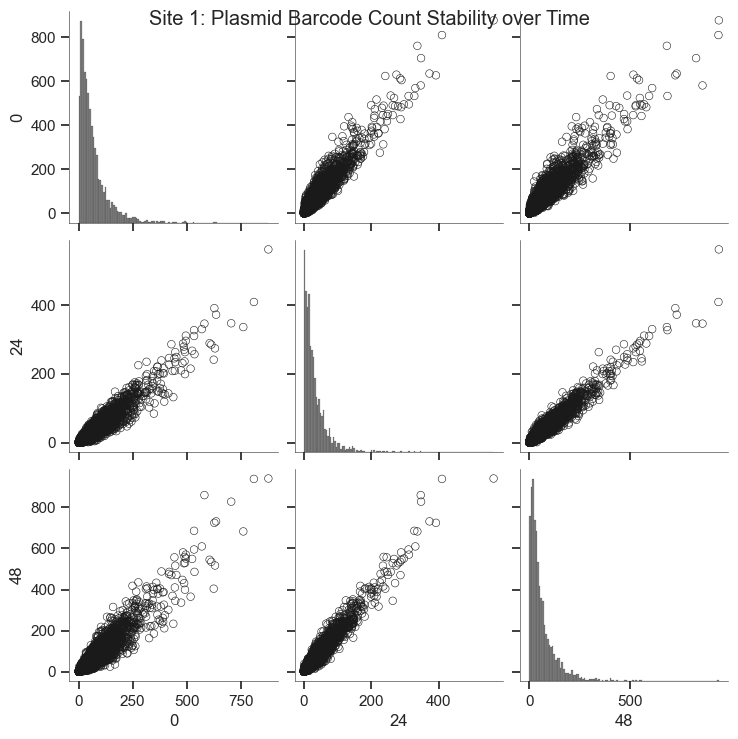

In [14]:
site1_rep1 = plasmid_barcode_df.loc[(plasmid_barcode_df["site"] == 1) &\
                                    (plasmid_barcode_df["rep"] == 1), :]\
                                .drop(["site", "rep", "type"], 1)\
                                .set_index("timepoint")

site2_rep1 = plasmid_barcode_df.loc[(plasmid_barcode_df["site"] == 2) &\
                                    (plasmid_barcode_df["rep"] == 1), :]\
                                .drop(["site", "rep", "type"], 1)\
                                .set_index("timepoint")

site3_rep1 = plasmid_barcode_df.loc[(plasmid_barcode_df["site"] == 3) &\
                                    (plasmid_barcode_df["rep"] == 1), :]\
                                .drop(["site", "rep", "type"], 1)\
                                .set_index("timepoint")

kws = {"s": 30, "facecolor": "none", "linewidth": 0.4, "edgecolor": "k"}
dkws = {"edgecolor": "k", "facecolor": "grey"}

sns.pairplot(site1_rep1.transpose(), plot_kws=kws, diag_kws=dkws)
plt.suptitle("Site 1: Plasmid Barcode Count Stability over Time")

# plt.savefig("PUB_plasmid_barcode_stability_over_time.svg", transparent=True, bbox_inches="tight")

## PERCENT WORKING:

In [122]:
def percent_working(x):
    # assumes working is "true" and not working is "false"
    # no NaNs allowed
    return sum(x)/len(x)

def make_pivot_percent_working(full_df, metric, column, info_df):
    metric_df = full_df.xs(metric, axis=1, level=2, drop_level=False)
    working_df = metric_df.mask(metric_df == 0, False)
    working_df = working_df.mask(working_df > 0, True)
    working_df = working_df.merge(info_df, how="left", on="barcode")
    working_melt = melt_data(working_df.reset_index())
    pivot = pd.pivot_table(data=working_melt.dropna(),
                           index=[column, "rep"],
                           values=metric,
                           aggfunc=percent_working).reset_index()
    return pivot

In [123]:
site1_dir = site1_full_df.loc[(site1_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site1_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site2_dir = site2_full_df.loc[(site2_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site2_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site3_dir = site3_full_df.loc[(site3_full_df[("barcode_info", "barcode_info", "donor_length")] == 64) |\
                              (site3_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]

# use only 64 & 94 lengths for donor direction, because those are the only lengths with R direction
site1_donor_dir_working_pivot_matched = make_pivot_percent_working(site1_dir, "barcode_rep_matched",
                                                               "donor_direction", site1_info).groupby("donor_direction").mean()
site2_donor_dir_working_pivot_matched = make_pivot_percent_working(site2_dir, "barcode_rep_matched",
                                                               "donor_direction", site2_info).groupby("donor_direction").mean()
site3_donor_dir_working_pivot_matched = make_pivot_percent_working(site3_dir, "barcode_rep_matched",
                                                               "donor_direction", site3_info).groupby("donor_direction").mean()
percent_working_dir = pd.concat([site1_donor_dir_working_pivot_matched,
                                 site2_donor_dir_working_pivot_matched,
                                 site3_donor_dir_working_pivot_matched]).reset_index()

site1_pam_pos_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "PAM_position", site1_info).groupby("PAM_position").mean()
site2_pam_pos_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "PAM_position", site2_info).groupby("PAM_position").mean()
site3_pam_pos_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "PAM_position", site3_info).groupby("PAM_position").mean()
percent_working_pam = pd.concat([site1_pam_pos_working_pivot_matched,
                                 site2_pam_pos_working_pivot_matched,
                                 site3_pam_pos_working_pivot_matched]).reset_index()


site1_donor_length_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "donor_length", site1_info).groupby("donor_length").mean()
site2_donor_length_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "donor_length", site2_info).groupby("donor_length").mean()
site3_donor_length_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "donor_length", site3_info).groupby("donor_length").mean()
percent_working_length = pd.concat([site1_donor_length_working_pivot_matched,
                                    site2_donor_length_working_pivot_matched,
                                    site3_donor_length_working_pivot_matched]).reset_index()


site1_chassis_number_working_pivot_matched = make_pivot_percent_working(site1_full_df, "barcode_rep_matched",
                                                               "chassis_number", site1_info).groupby("chassis_number").mean()
site2_chassis_number_working_pivot_matched = make_pivot_percent_working(site2_full_df, "barcode_rep_matched",
                                                               "chassis_number", site2_info).groupby("chassis_number").mean()
site3_chassis_number_working_pivot_matched = make_pivot_percent_working(site3_full_df, "barcode_rep_matched",
                                                               "chassis_number", site3_info).groupby("chassis_number").mean()
percent_working_chassis = pd.concat([site1_chassis_number_working_pivot_matched,
                                    site2_chassis_number_working_pivot_matched,
                                    site3_chassis_number_working_pivot_matched]).reset_index()


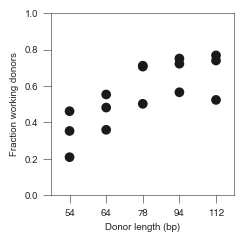

In [125]:
# donor length:
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

sns.stripplot(data=percent_working_length,
              x="donor_length",
              y="barcode_rep_matched",
              color="k",
              s=7,
              ax=ax,
              order=[54.0, 64.0, 78.0, 94.0, 112.0],
              jitter=False)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Fraction working donors", fontsize=7)
ax.set_xlabel("Donor length (bp)", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticklabels([54, 64, 78, 94, 112], fontsize=7, font="Helvetica")
plt.savefig("PUB_SUPP_length_fraction_working.svg", transparent=True, bbox_inches="tight")

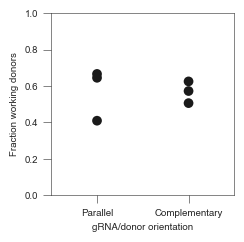

In [126]:
# donor length:
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

sns.stripplot(data=percent_working_dir,
              x="donor_direction",
              y="barcode_rep_matched",
              color="k",
              s=7,
              ax=ax,
              order=["F", "R"],
              jitter=False)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Fraction working donors", fontsize=7)
ax.set_xlabel("gRNA/donor orientation", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticklabels(["Parallel", "Complementary"], fontsize=7, font="Helvetica")
plt.savefig("PUB_SUPP_dir_fraction_working.svg", transparent=True, bbox_inches="tight")

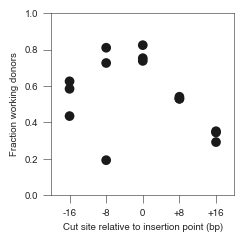

In [50]:
# donor length:
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

sns.stripplot(data=percent_working_pam,
              x="PAM_position",
              y="barcode_rep_matched",
              color="k",
              s=7,
              ax=ax,
              order=[-13, -5, -3, 11, 19],
              jitter=False)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Fraction working donors", fontsize=7)
ax.set_xlabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")
plt.savefig("PUB_SUPP_pam_fraction_working.svg", transparent=True, bbox_inches="tight")

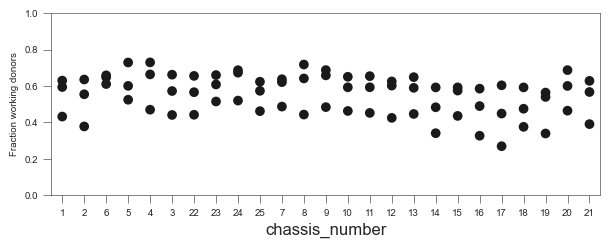

In [127]:
# donor length:
fig, ax = plt.subplots(figsize=(18*cm, 6*cm))

sns.stripplot(data=percent_working_chassis,
              x="chassis_number",
              y="barcode_rep_matched",
              color="k",
              s=7,
              ax=ax,
              order=[1, 2, 6, 5, 4, 3, 22, 23, 24, 25, 7, 8, 9, 10, 11, 12, 13,
                     14, 15, 16, 17, 18, 19, 20, 21],
              jitter=False)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Fraction working donors", fontsize=7)
# ax.set_xlabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica")
ax.tick_params(axis='both', which='major', labelsize=7)
# ax.set_xticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")
plt.savefig("PUB_SUPP_chassis_fraction_working.svg", transparent=True, bbox_inches="tight")

In [60]:
def percent_working(x):
    # assumes working is "true" and not working is "false"
    # no NaNs allowed
    return sum(x)/len(x)

def make_pivot_percent_working_two_axis(full_df, metric, column_array, info_df):
    metric_df = full_df.xs(metric, axis=1, level=2, drop_level=False)
    working_df = metric_df.mask(metric_df == 0, False)
    working_df = working_df.mask(working_df > 0, True)
    working_df = working_df.merge(info_df, how="left", on="barcode")
    working_melt = melt_data(working_df.reset_index())
    pivot = pd.pivot_table(data=working_melt.dropna(),
                           index=[column_array[0], column_array[1], "rep"],
                           values=metric,
                           aggfunc=percent_working).reset_index()
    return pivot

In [88]:
site1_center_data = site1_full_df.loc[(site1_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site2_center_data = site2_full_df.loc[(site2_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]
site3_center_data = site3_full_df.loc[(site3_full_df[("barcode_info", "barcode_info", "donor_length")] == 94), :]

site1_center = make_pivot_percent_working_two_axis(site1_center_data, "barcode_rep_matched", ["donor_center", "PAM_position"], site1_info).groupby(["donor_center", "PAM_position"]).mean()
site2_center = make_pivot_percent_working_two_axis(site2_center_data, "barcode_rep_matched", ["donor_center", "PAM_position"], site2_info).groupby(["donor_center", "PAM_position"]).mean()
site3_center = make_pivot_percent_working_two_axis(site3_center_data, "barcode_rep_matched", ["donor_center", "PAM_position"], site3_info).groupby(["donor_center", "PAM_position"]).mean()

percent_working_center = pd.concat([site1_center,
                                    site2_center,
                                    site3_center]).reset_index()

In [90]:
percent_working_center = percent_working_center.pivot_table(index="PAM_position", columns="donor_center", values="barcode_rep_matched", aggfunc="mean")

In [91]:
percent_working_center

donor_center,-20.0,-10.0,0.0,14.0,28.0
PAM_position,,,,,
-13.0,0.672849,0.830334,0.859986,0.797676,0.232470
-5.0,0.574843,0.662907,0.741377,0.696798,0.403038
-3.0,0.521716,0.872218,0.912508,0.942223,0.900160
11.0,0.138805,0.676992,0.881396,0.935197,0.898619
19.0,0.136705,0.238168,0.569811,0.833760,0.710964


<AxesSubplot:xlabel='donor_center', ylabel='PAM_position'>

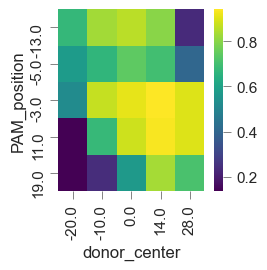

In [102]:
fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

sns.heatmap(percent_working_center, ax=ax,
            cbar_kws={"label": None}, cmap="viridis", clip_on=False)
ax.set_title("94 bp donor length: fraction working donors", fontsize=7, font="Helvetica")
ax.set_ylabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica")
ax.set_yticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")
ax.set_xlabel("Donor center relative to insertion point (bp)",
                 fontsize=7, font="Helvetica")
ax.set_xticklabels(["-25", "-15", "-5", "+9", "+23"], fontsize=7, font="Helvetica")
plt.yticks(fontsize=7)
plt.savefig("PUB_SUPP_center_fraction_working.svg", transparent=True, bbox_inches="tight")

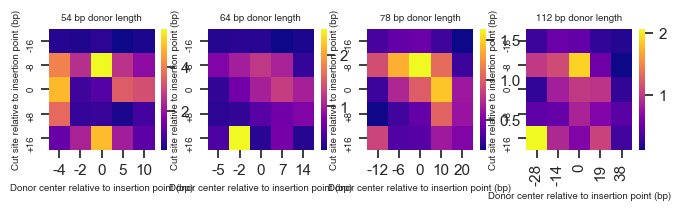

In [137]:
# all other heatmaps for lengths!!!

fig, ax = plt.subplots(1, 4, figsize=(20*cm, 4*cm))
index = 0

for key in heatmap_data.keys():
    if key == 94.0:
        continue
    length_data = heatmap_data[key]
    sns.heatmap(length_data.droplevel(0, axis=1), ax=ax[index],
                cbar_kws={"label": None}, cmap="plasma", clip_on=False)
    ax[index].set_title("%i bp donor length"%key, fontsize=7, font="Helvetica")
    ax[index].set_ylabel("Cut site relative to insertion point (bp)", fontsize=7, font="Helvetica")
    ax[index].set_yticklabels(["-16", "-8", "0", "+8", "+16"], fontsize=7, font="Helvetica")
    ax[index].set_xlabel("Donor center relative to insertion point (bp)",
                     fontsize=7, font="Helvetica")
#     ax[index].set_xticklabels(["-25", "-15", "-5", "+9", "+23"], fontsize=7, font="Helvetica")
    plt.yticks(fontsize=7)
    index += 1

plt.savefig("PUB_SUPP_other_donor_centers.svg", transparent=True, bbox_inches="tight")

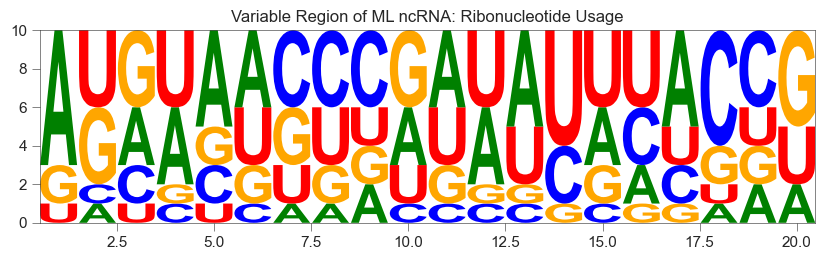

In [16]:
# logo mapper for ML supplementary figures
def logo_mapper(strings):    
    # Initialize a list of dictionaries to count letter frequencies at each position
    logo_map = [defaultdict(int) for _ in range(len(strings[0]))]
    for string in strings:
        for i, char in enumerate(string):
            logo_map[i][char] += 1
            
    # Convert the list of defaultdicts to a DataFrame
    frequency_matrix = pd.DataFrame(logo_map).fillna(0)
    frequency_matrix.index = list(range(1, len(strings[0]) + 1))
    
    # Create a sequence logo using logomaker
    logo = logomaker.Logo(frequency_matrix, color_scheme="classic")
    
    return logo

# Example usage
strings = [
    "UAUCAUGUAAUACUCUACGG",
    "AUAUCGGCGUAAUUUCGGUU",
    "AUCUAUCGUGAUAUUCAGAU",
    "AUAUGGACACGGUGAGCACU",
    "AUCAUUUACGGUACGAUCAG",
    "AGGAAAUCCAACAUUCACUG",
    "GGAUCACUCACUGUAUACCG",
    "GCGGGCGGUGUAACGUUCCA",
    "AGGAAACUGUAAAUAAACCG",
    "AGGAAACCCGUUUCUUCUGA",
]

logo = logo_mapper(strings)
logo.ax.set_title('Variable Region of ML ncRNA: Ribonucleotide Usage')
plt.savefig("PUB_SUPP_ML_logomaker.svg", transparent=True, bbox_inches="tight")